In [4]:
!pip install -U datasets


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 480.6/480.6 kB 32.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 12.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.3/179.3 kB 17.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 13.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 18.3 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2024.10.0
    Uninstalling fsspec-2024.10.0:
      Successfully uninstalled fsspec-2024.10.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2024.10.0 requires fsspec==2024.10.0, but you have fsspec 2024.9.0 which is incompatible.


In [5]:
!pip install evaluate

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.0/84.0 kB 8.6 MB/s eta 0:00:00


In [3]:
from transformers import DistilBertTokenizer, DistilBertForSequenceClassification, Trainer, TrainingArguments
from torch.utils.data import Dataset
from sklearn.model_selection import train_test_split
import pandas as pd
import torch

In [6]:

# Load dataset, replace link with your own file, or alternatively use the file included with the repo
file_path = '/content/drive/MyDrive/sentiment analysis/LatestTrain.csv'
data = pd.read_csv(file_path, encoding='latin1') #encode it from utf-8 to latin1
data = data[['text', 'sentiment']].dropna()

'''
This mapping is specific to the provided file. It is only here to map
the 'positive', 'neutral' and 'negative' labels to numbers for training
'''

sentiment_mapping = {'positive': 2, 'neutral': 1, 'negative': 0}
data['sentiment'] = data['sentiment'].map(sentiment_mapping)

# Use 80:20 split
train_texts, val_texts, train_labels, val_labels = train_test_split(
    data['text'].tolist(),
    data['sentiment'].tolist(),
    test_size=0.2,
    random_state=42
)

In [7]:
# Tokenise the data
tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')
train_encodings = tokenizer(train_texts, truncation=True, padding=True, max_length=128)
val_encodings = tokenizer(val_texts, truncation=True, padding=True, max_length=128)

# Create Dataset class
class SentimentDataset(Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item

train_dataset = SentimentDataset(train_encodings, train_labels)
val_dataset = SentimentDataset(val_encodings, val_labels)

# Load DistilBERT model
model = DistilBertForSequenceClassification.from_pretrained('distilbert-base-uncased', num_labels=3)

#training args. You are welcome to change the parameters here, e.g. the number of epochs
training_args = TrainingArguments(
    output_dir='./results',
    eval_strategy="epoch",
    save_strategy="epoch",
    logging_dir='./logs',
    logging_steps=200,
    num_train_epochs=2,
    per_device_train_batch_size=16,
    save_total_limit=2,
    load_best_model_at_end=True,
    metric_for_best_model="eval_loss",
    remove_unused_columns=False,
)

# Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
)

# Train the model
trainer.train()

# Evaluate the model
results = trainer.evaluate()
print(results)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
wandb: WARNING The `run_name` is currently set to the same value as `TrainingArguments.output_dir`. If this was not intended, please specify a different run name by setting the `TrainingArguments.run_name` parameter.
wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

 ··········


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


Epoch,Training Loss,Validation Loss
1,No log,0.679714
2,No log,0.642754


{'eval_loss': 0.6427540183067322, 'eval_runtime': 0.5532, 'eval_samples_per_second': 542.32, 'eval_steps_per_second': 68.694, 'epoch': 2.0}


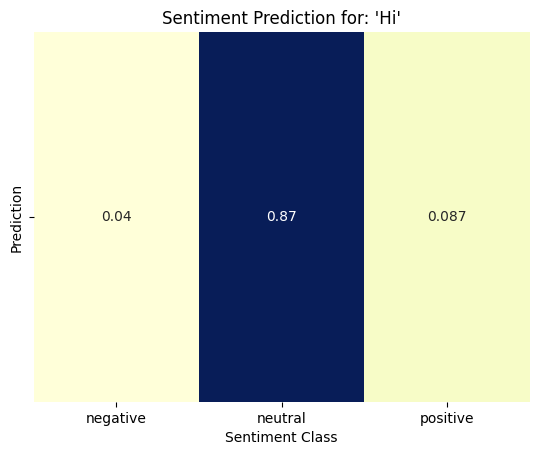

Text: Hi
Predicted Sentiment: neutral


In [33]:
#Test it against a custom input. This creates a heat map which visually represents the probabilities of each sentiment class
import seaborn as sns
import matplotlib.pyplot as plt
import torch

def predict_sentiment_with_heatmap(text):
    """Predict sentiment and plot a heatmap of class probabilities."""

    inputs = tokenizer(text, return_tensors="pt", truncation=True, padding=True, max_length=128)
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    inputs = {key: val.to(device) for key, val in inputs.items()}


    model.eval()


    with torch.no_grad():
        outputs = model(**inputs)
        probs = torch.nn.functional.softmax(outputs.logits, dim=-1).cpu().numpy()[0]


    sentiment_map = {0: "negative", 1: "neutral", 2: "positive"}
    predicted_class = sentiment_map[torch.argmax(torch.tensor(probs)).item()]

    # Plot the heatmap
    labels = ["negative", "neutral", "positive"]
    sns.heatmap([probs], annot=True, cbar=False, xticklabels=labels, yticklabels=["Prediction"], cmap="YlGnBu")
    plt.title(f"Sentiment Prediction for: '{text}'")
    plt.xlabel("Sentiment Class")
    plt.ylabel("")
    plt.show()

    return predicted_class


custom_text = "Hi"
predicted_sentiment = predict_sentiment_with_heatmap(custom_text)

print(f"Text: {custom_text}")
print(f"Predicted Sentiment: {predicted_sentiment}")